<a href="https://colab.research.google.com/github/aburak256/Currency-with-Twitter/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving requirements.txt to requirements.txt
User uploaded file "requirements.txt" with length 357 bytes


In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 7.5MB 5.1MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 1.2MB 39.6MB/s 
     |████████████████████████████████| 10.5MB 21.3MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 235kB 45.4MB/s 
     |████████████████████████████████| 17.3MB 238kB/s 
     |████████████████████████████████| 28.4MB 99kB/s 
     |████████████████████████████████| 327kB 50.1MB/s 
     |████████████████████████████████| 86.4MB 46kB/s 
     |████████████████████████████████| 12.4MB 19.2MB/s 
     |████████████████████████████████| 8.7MB 20.1MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 1.1MB 45.4MB/s 
     |████████████████████████████████| 276kB 42.2MB/s 
     |████████████████████████████████| 133kB 41.1MB/s 
     |████████████████████████████████| 194kB 46.0MB/s 
 

In [1]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones


from pandas.plotting import autocorrelation_plot
from metrics import evaluate
from plots import bar_metrics
from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

INFO:root:Using CPU


2.0.3


In [2]:
url = 'https://raw.githubusercontent.com/aburak256/Currency-with-Twitter/main/Sum_Last.csv?token=AIJJRBHQ566QWR63THDRYHS7UF3LE'



In [3]:
exchange_rate = pd.read_csv('Last.csv',parse_dates=['Date'])
exchange_rate.set_index('Date',inplace=True)
exchange_rate.head() #

,Rate,Previous,Lag1Order2
Date,,,
2014-01-01 18:00:00,2.14686,2.14793,0.00054
2014-01-01 19:01:00,2.14680,2.14686,-0.00045
2014-01-01 20:00:00,2.14728,2.14680,-0.00037
2014-01-01 21:00:00,2.14731,2.14728,0.00034
2014-01-01 22:01:00,2.14697,2.14731,-0.00041


In [6]:
exchange_rate.describe()

,Rate,Previous
count,37198.000000,37198.000000
mean,3.687798,3.687696
std,1.283924,1.283895
min,2.063250,2.063250
25%,2.707725,2.707680
50%,3.469870,3.469440
75%,4.734820,4.734745
max,7.096780,7.096780


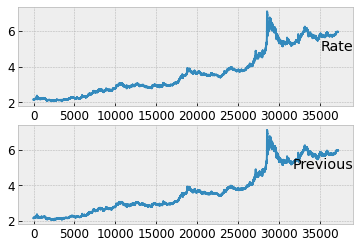

In [7]:
values = exchange_rate.values
groups = [0, 1]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(exchange_rate.columns[group], y=0.5, loc='right')
    i += 1
    

plt.show()

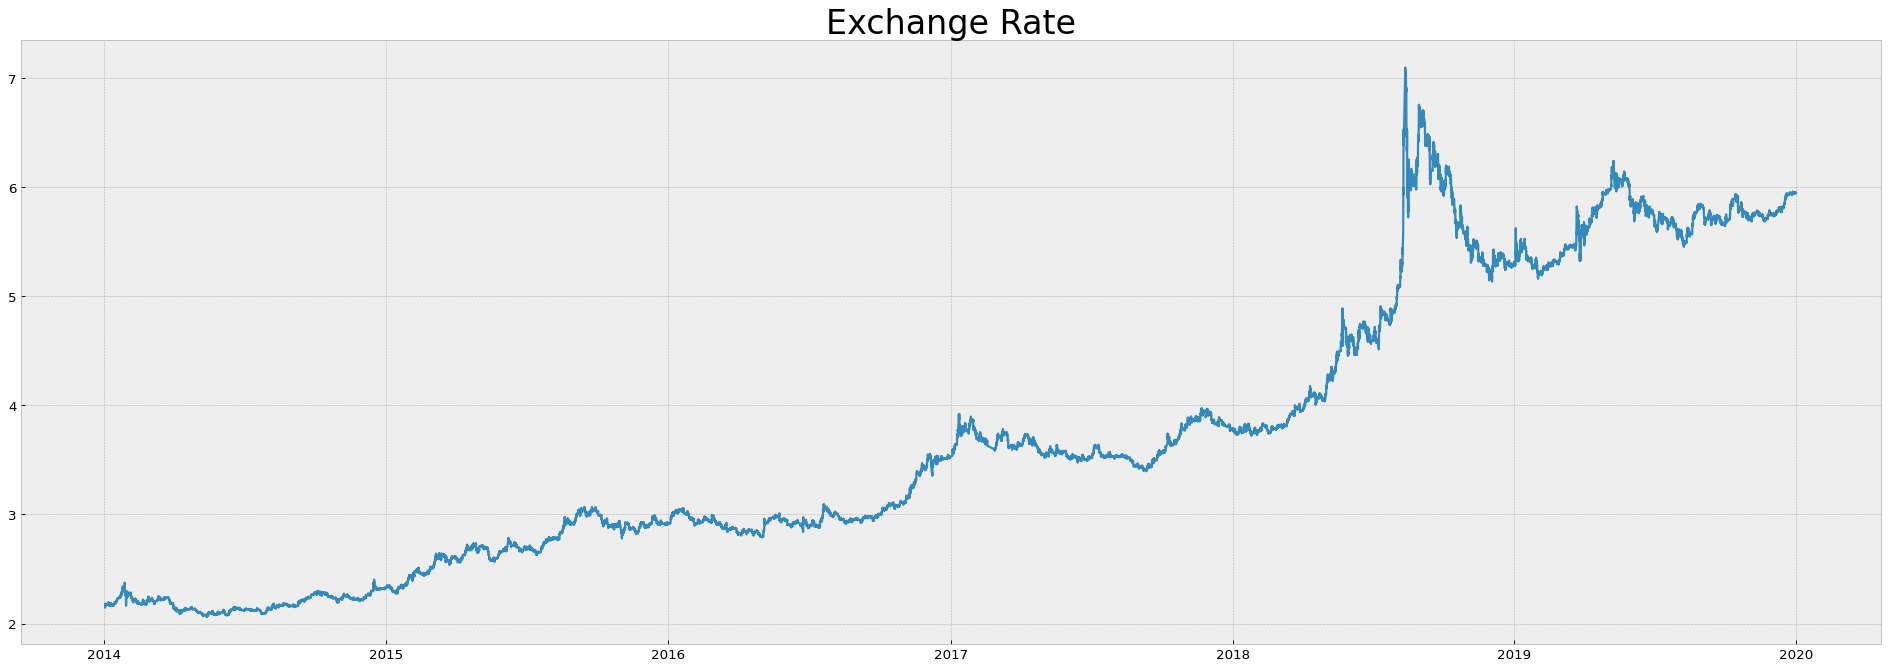

In [8]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Exchange Rate',fontsize=30)

plt.plot(exchange_rate.Rate)
plt.savefig("pollution.png")

<Figure size 4000x1600 with 0 Axes>

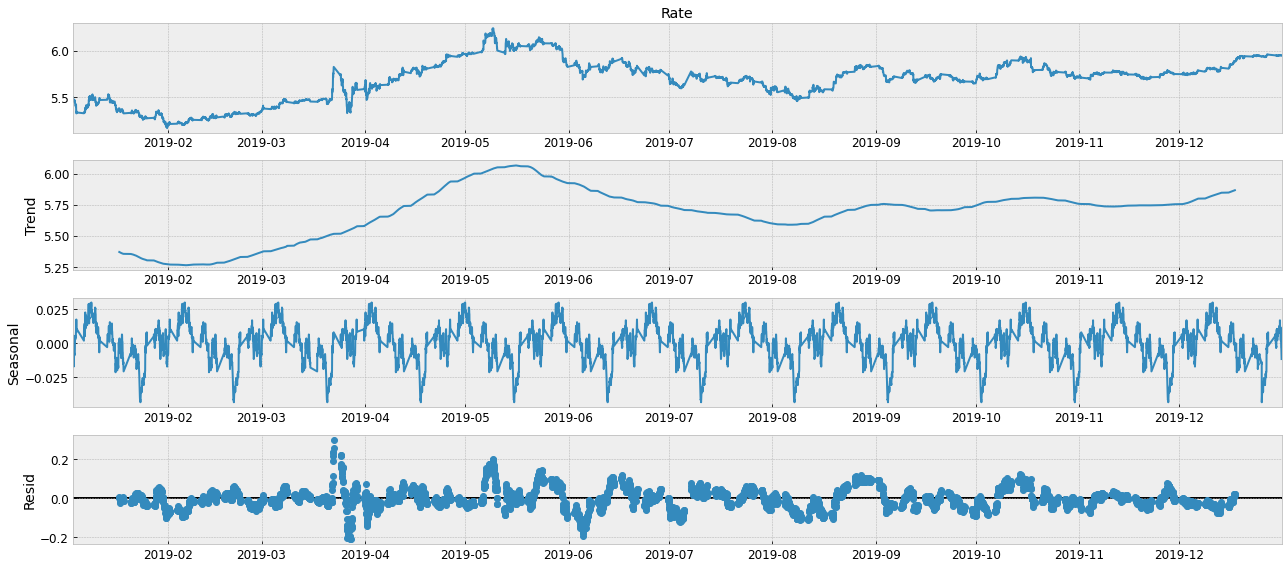

In [9]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = exchange_rate.Rate[-6200:]
result = seasonal_decompose(series, model='additive',period=480 )#additive because seasonality’s amplitude is independent of the level , period = 24* 20 (20 trading days per month)
result.plot()
pass

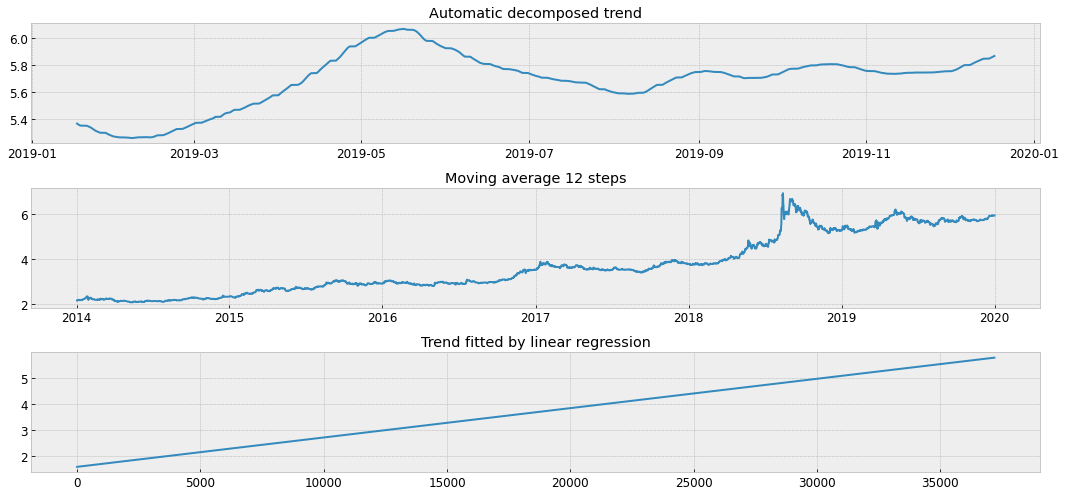

In [10]:

fig = plt.figure(figsize=(15, 7))
layout = (3,2)
pm_ax = plt.subplot2grid(layout, (0,0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1,0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2,0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = exchange_rate.Rate.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(exchange_rate.Rate))]
X = np.reshape(X, (len(X), 1))
y = exchange_rate.Rate.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


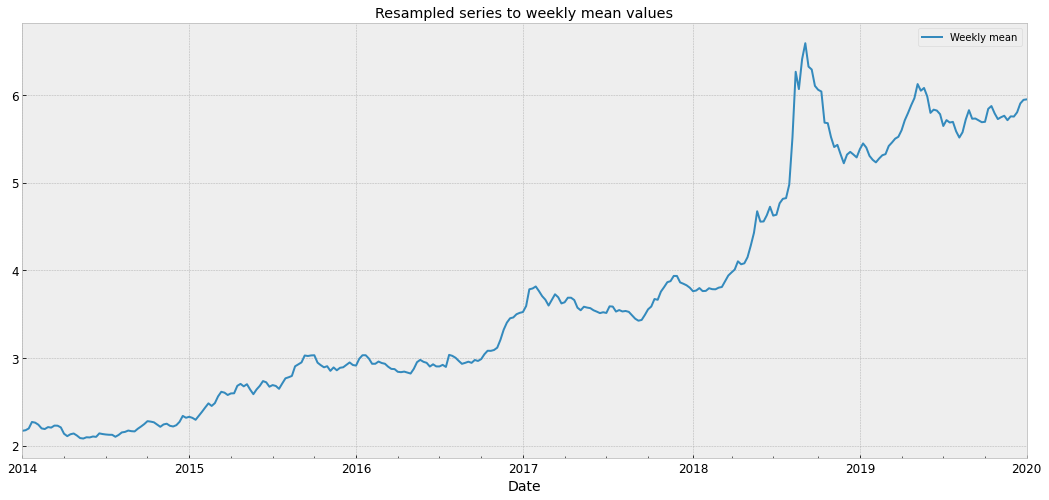

In [11]:
#Looking for weekly seasonality
resample = exchange_rate.resample('W')
weekly_mean = resample.mean()
weekly_mean.Rate.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

Text(0.5, 1.0, 'Mean over time')

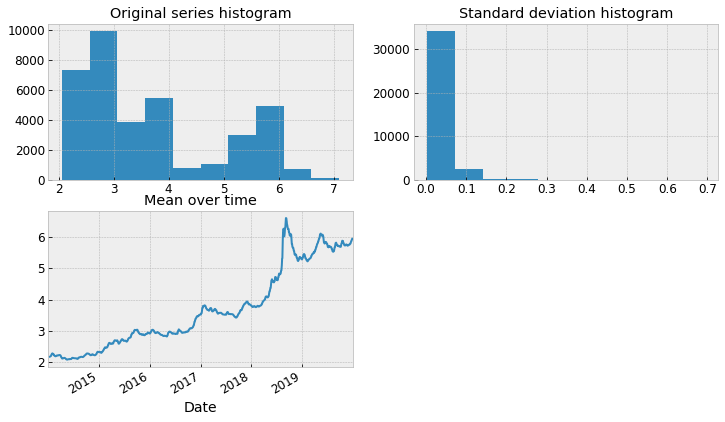

In [12]:
series = exchange_rate.Rate.values
fig = plt.figure(figsize=(12, 7))
layout = (2,2)
hist_ax = plt.subplot2grid(layout, (0,0))
hist_std_ax = plt.subplot2grid(layout, (0,1))
mean_ax = plt.subplot2grid(layout, (1,0))

exchange_rate.Rate.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

mm = exchange_rate.Rate.rolling(168).std()#168 hours at 1 week
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = exchange_rate.Rate.rolling(168).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

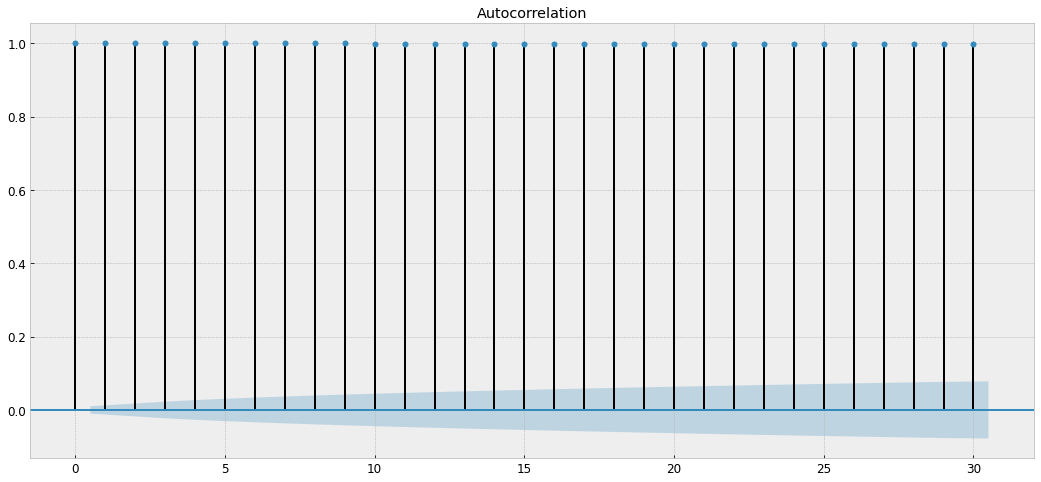

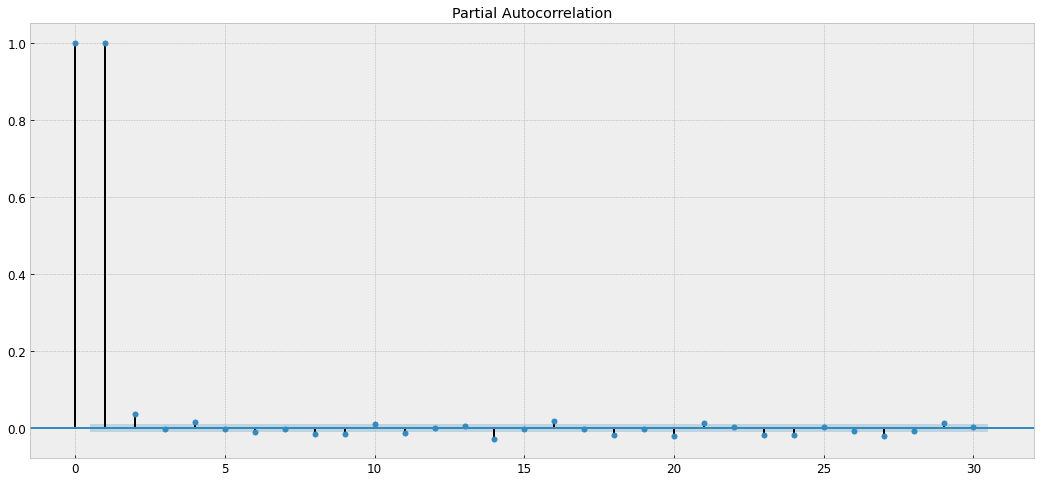

In [13]:
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time. But if we look at our autocorrelation graph it wont decrease over time.
These graphs shows us that our data is not stationary 

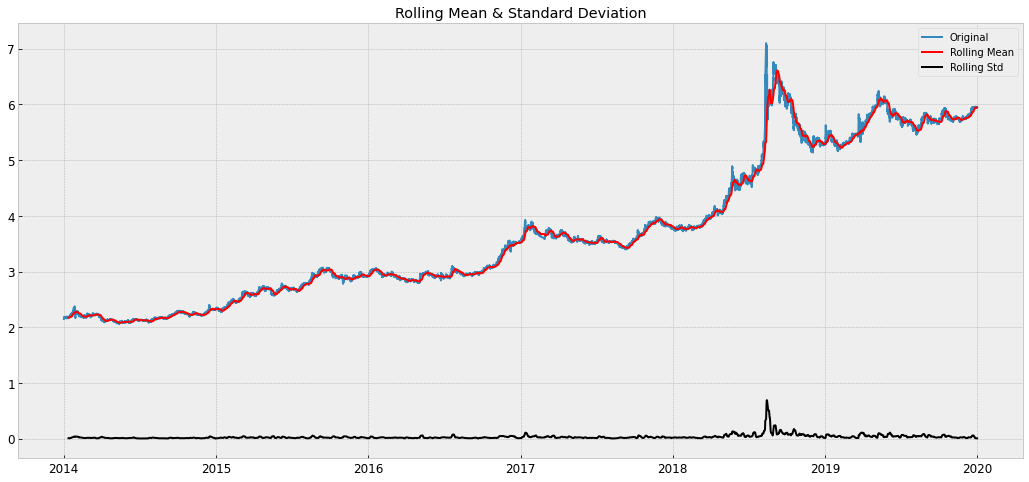

In [14]:
rolmean = exchange_rate.Rate.rolling(window=168).mean()#168 hours at 1 week
rolstd = exchange_rate.Rate.rolling(window=168).std()

#Plot rolling statistics:
orig = plt.plot(exchange_rate.Rate,label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Also we can see that our data is not stationary using standart deviation. Mean and standard deviation should be constant over time in order to have a stationary time series.

In [15]:
X = exchange_rate.Rate.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.240683
p-value: 0.933495
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


**The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. if p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary**

## Making time series stationary

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

difference(t) = observation(t) - observation(t-1)

In [16]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset=diff
    return diff

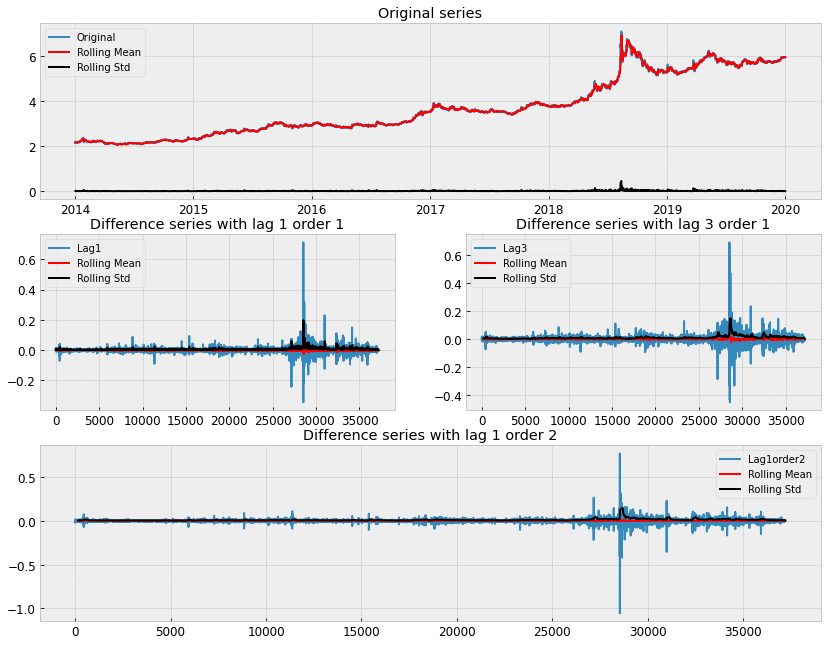

In [25]:
lag1series = pd.Series(difference(exchange_rate.Rate, interval=1, order=1))
lag3series = pd.Series(difference(exchange_rate.Rate, interval=3, order=1))
lag1order2series = pd.Series(difference(exchange_rate.Rate, interval=1, order=2))

fig = plt.figure(figsize=(14,11))
layout = (3,2)
original = plt.subplot2grid(layout, (0,0), colspan=2)
lag1 = plt.subplot2grid(layout, (1,0))
lag3 = plt.subplot2grid(layout, (1,1))
lag1order2 = plt.subplot2grid(layout, (2,0), colspan=2)

original.set_title('Original series')
original.plot(exchange_rate.Rate, label = 'Original')
original.plot(exchange_rate.Rate.rolling(24).mean(), color='red', label='Rolling Mean')
original.plot(exchange_rate.Rate.rolling(24).std(), color='black', label = 'Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label = "Lag1")
lag1.plot(lag1series.rolling(24).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(24).std(), color='black', label = 'Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label = "Lag3")
lag3.plot(lag3series.rolling(168).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(168).std(), color='black', label = 'Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label = "Lag1order2")
lag1order2.plot(lag1order2series.rolling(168).mean(), color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(168).std(), color='black', label = 'Rolling Std')
lag1order2.legend(loc='best')

In [11]:
resultsDict={}
predictionsDict={}

split_date ='2019-12-25 00:00'
df_training = exchange_rate.loc[exchange_rate.index <= split_date]
df_test = exchange_rate.loc[exchange_rate.index > split_date]
print(f"{len(df_training)} hours of training data \n {len(df_test)} hours of testing data ")


df_training.to_csv('training.csv')
df_test.to_csv('test.csv')


37086 hours of training data 
 110 hours of testing data 


In [12]:
mean = df_test.Rate.mean()
mean = np.array([mean for u in range(len(df_test))])
resultsDict['Naive mean'] = evaluate(df_test.Rate, mean)
predictionsDict['Naive mean'] = mean
resultsDict['Yesterdays value'] = evaluate(df_test.Rate, df_test.Previous)
predictionsDict['Yesterdays value'] = df_test.Previous.values

**Simple Exponential Smoothing (SES)**

The Simple Exponential Smoothing (SES) method models the next time step as an exponentially weighted linear function of observations at prior time steps. This method expects our time series to be non stationary in order to perform adecuately (no trend or seasonality)

In [108]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.Lag1Order2)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.Lag1Order2, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 526/526 [01:26<00:00,  6.10it/s]


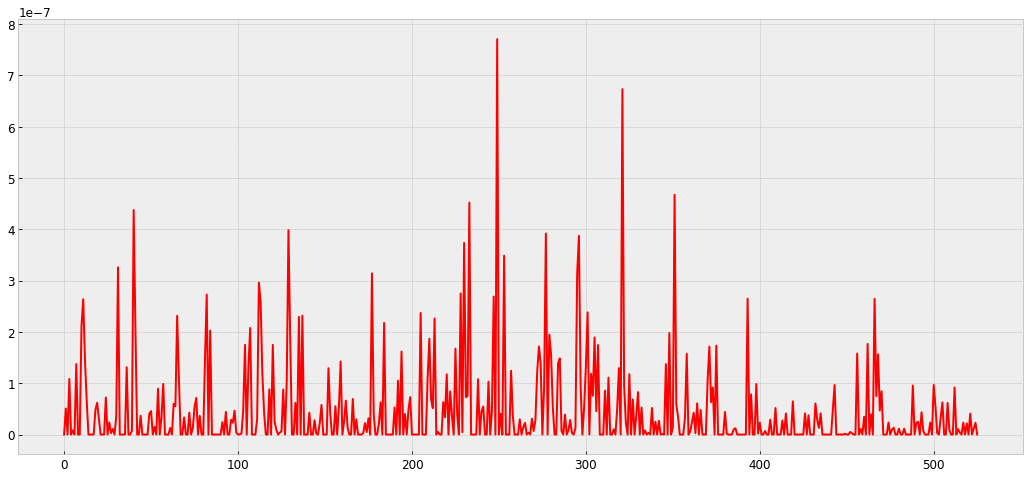

In [109]:

plt.plot(yhat.values,color='red',label='SES predicted with Lag1Order2')
plt.show()

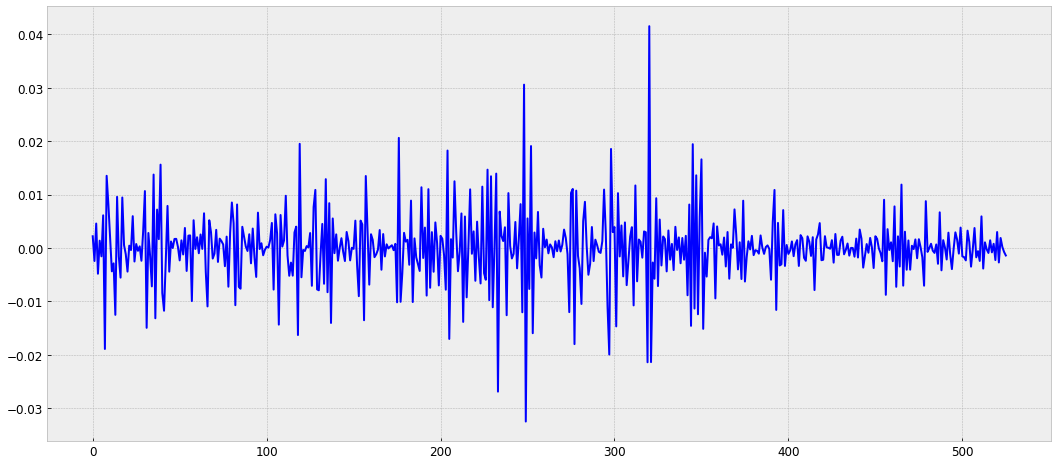

In [110]:
plt.plot(df_test.Lag1Order2.values,color='blue',label='Original Lag1')
plt.show()

In [102]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.Rate)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 526/526 [01:24<00:00,  6.20it/s]


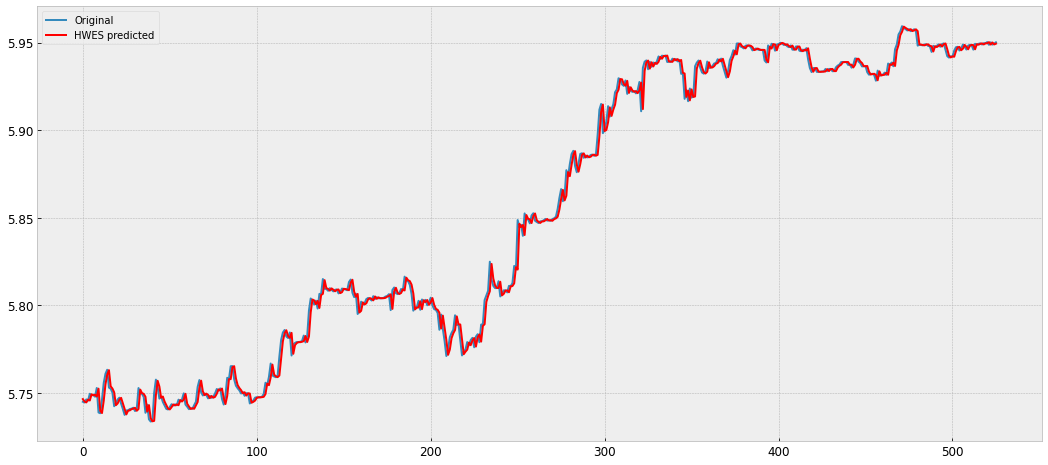

In [106]:
plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='SES predicted with Rate')
plt.legend()

In [85]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.Rate)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 526/526 [01:24<00:00,  6.25it/s]


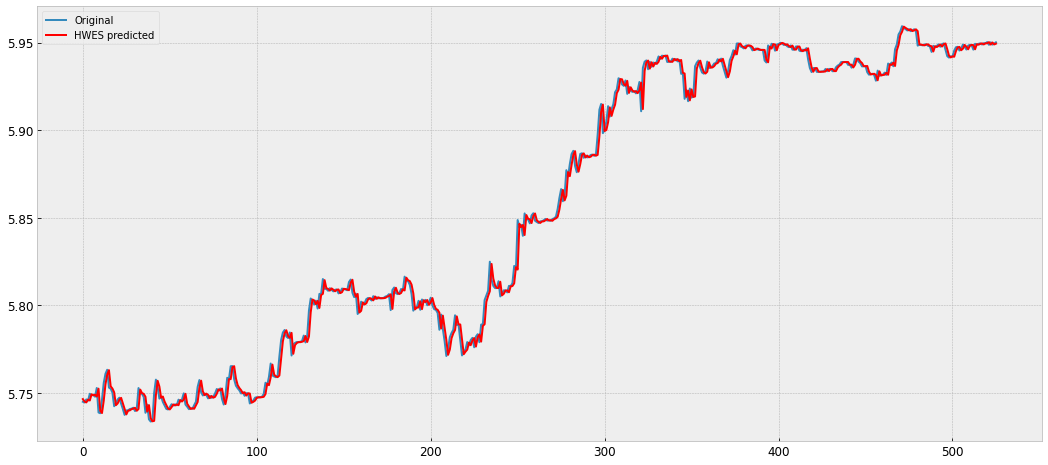

In [86]:

plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='HWES predicted')
plt.legend()

In [117]:
index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = AR(temp_train.Rate)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 182/182 [01:26<00:00,  2.11it/s]


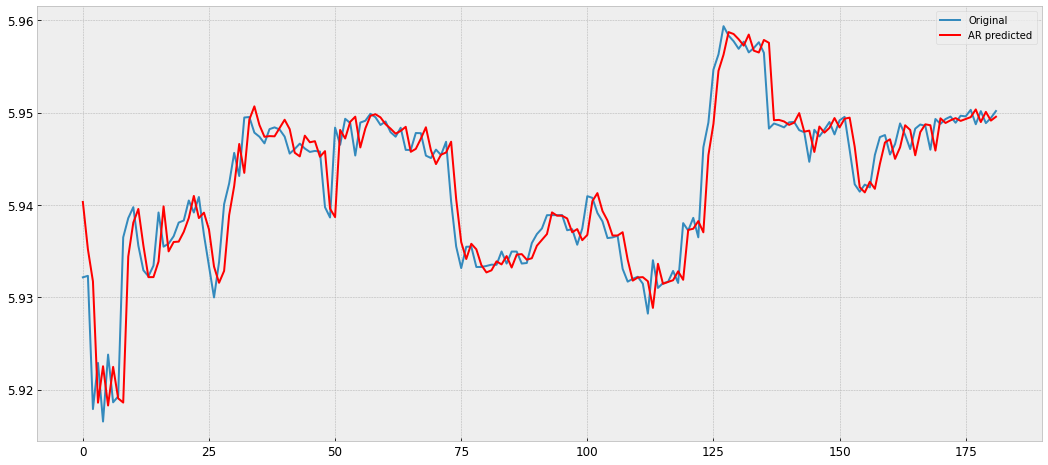

In [118]:
plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
plt.legend()

**Moving Average**

In [120]:
from statsmodels.tsa.arima_model import ARMA
from random import random

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = ARMA(temp_train.Rate, order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 182/182 [11:34<00:00,  3.82s/it]


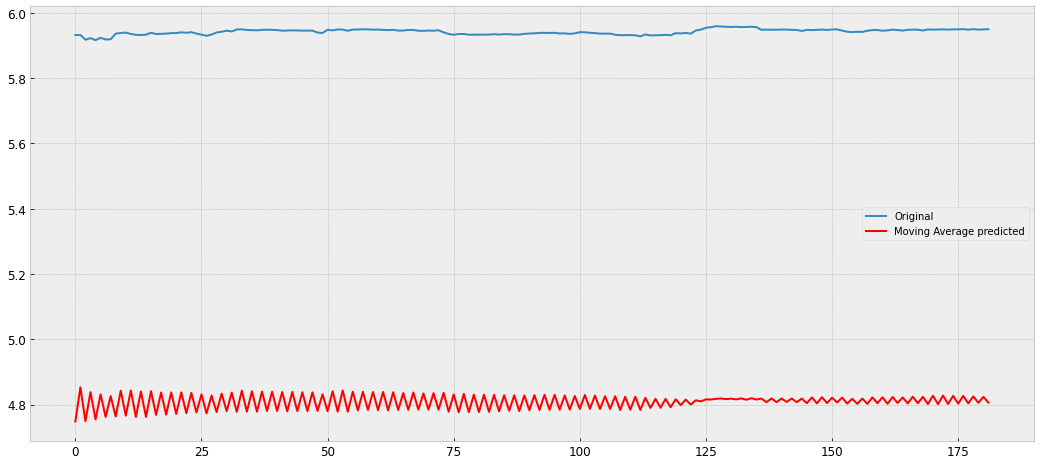

In [121]:
plt.plot(df_test.Rate.values, label='Original')
plt.plot(yhat.values,color='red',label='Moving Average predicted')
plt.legend()

In [ ]:
from statsmodels.tsa.arima_model import ARMA
from random import random

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = ARMA(temp_train.Rate, order=(1, 1))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['ARMA'] = yhat.values

  0%|          | 0/86 [00:00<?, ?it/s]

## Couldn't get the results. RAM was insufficent

In [7]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = ARIMA(temp_train.Rate,order=(1,0, 0))
    model_fit = model.fit(display = False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 110/110 [02:43<00:00,  1.49s/it]


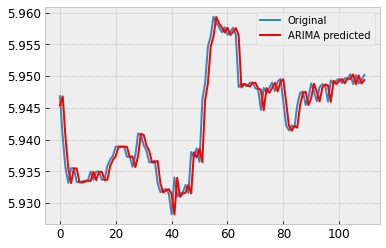

In [9]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
plt.legend()

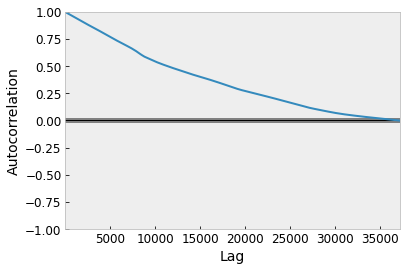

In [14]:
autocorrelation_plot(exchange_rate)

In [24]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

index = len(df_training)
yhat = list()
# Walk throught the test data, training and predicting 1 day ahead for all the test data
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = ARIMA(temp_train.Rate,order=(5,1, 0))#2 lagged 1 ordered time series
    model_fit = model.fit(display = False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 110/110 [02:47<00:00,  1.52s/it]


In [26]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE: %.8f' % error)

Test MSE: 35.31823883


In [27]:
temp_train.Rate

Date
2014-01-01 18:00:00    2.14686
2014-01-01 19:01:00    2.14680
2014-01-01 20:00:00    2.14728
2014-01-01 21:00:00    2.14731
2014-01-01 22:01:00    2.14697
                        ...   
2019-12-31 09:00:00    5.95030
2019-12-31 10:00:00    5.94874
2019-12-31 11:00:00    5.95016
2019-12-31 12:00:00    5.94886
2019-12-31 13:00:00    5.94942
Name: Rate, Length: 37195, dtype: float64

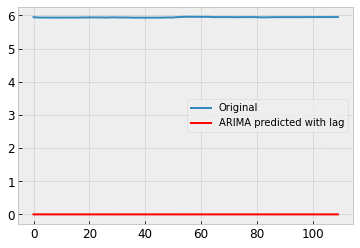

In [25]:
plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted with lag')
plt.legend()

## Auto ARIMA

predicted=5.958749, expected=5.957680
predicted=5.956052, expected=5.956520
predicted=5.957979, expected=5.957000
predicted=5.956177, expected=5.957620
predicted=5.958230, expected=5.956480
predicted=5.956229, expected=5.948270
predicted=5.948858, expected=5.948820
predicted=5.948428, expected=5.948630
predicted=5.948580, expected=5.948400
predicted=5.947412, expected=5.948950
predicted=5.948745, expected=5.948990
predicted=5.947575, expected=5.948100
predicted=5.948293, expected=5.947870
predicted=5.947962, expected=5.944670
predicted=5.945863, expected=5.948140
predicted=5.947234, expected=5.947420
predicted=5.947434, expected=5.948160
predicted=5.947865, expected=5.948980
predicted=5.948943, expected=5.947640
predicted=5.947315, expected=5.949160
predicted=5.949827, expected=5.949540
predicted=5.949268, expected=5.945960
predicted=5.946973, expected=5.942240
predicted=5.941299, expected=5.941440
predicted=5.941610, expected=5.942200
predicted=5.941961, expected=5.941900
predicted=5.

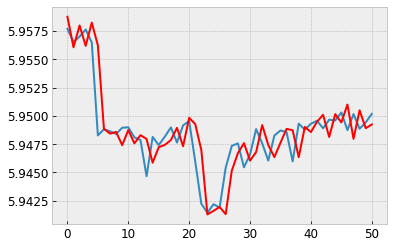

In [20]:
X = exchange_rate.Rate[-150:].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(10,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


Test MSE: 0.00000405


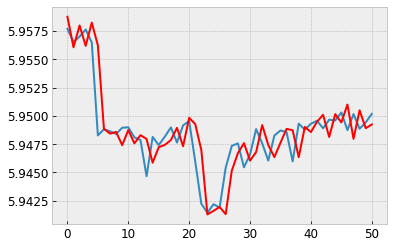

In [22]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.8f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [ ]:
autoModel = pm.auto_arima(df_training.Rate, trace=True, error_action='ignore', suppress_warnings=True,seasonal=False)
autoModel.fit(df_training.Rate)

## Not sufficent RAM again

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.Rate))):
    temp_train = exchange_rate[:len(df_training)+t]
    model = SARIMAX(temp_train.Rate, order=(1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test.Rate, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 110/110 [13:00<00:00,  7.09s/it]


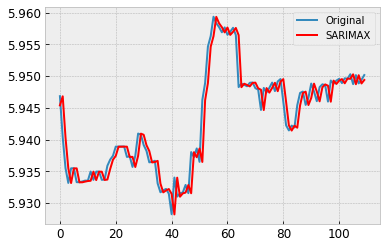

In [9]:

plt.plot(df_test.Rate.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.legend()

In [15]:
error = mean_squared_error(df_test.Rate, yhat.values)
print('Test MSE for SARIMAX: %.8f' % error)

Test MSE for SARIMAX: 0.00000536
